In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

##### Read features as dataframes

In [2]:
year_range = [f'{i}_{i+2}' for i in range(1990,2020,3)]

In [3]:
year_name = [f'Landsat_{year}' for year in year_range] + [f'Sentinel_{year}' for year in year_range[-2:]]

In [4]:
# import the points with image values 
feature_df = [pd.read_csv(f'./Data/{name}.csv') for name in year_name]

# merge all pt_with_img and remove unnecessary columns
feature_df = [fe.drop(['system:index','.geo','split'],axis=1) for fe in feature_df]

##### train_test_split and apply randomforest_classifier

In [5]:
grid_acc_list = []

for flag,fe in enumerate(feature_df):
    
    # get the X and y
    X = fe.drop('Built',axis=1)
    y = fe['Built']

    # appliy RandomForestClassifier 
    classifier = RandomForestClassifier()
    
    # Use gridSearch
    param_grid = dict(n_estimators = range(1,80))    
    grid = GridSearchCV(classifier,param_grid,cv=4,scoring='accuracy',n_jobs=-1,verbose=2)
    grid.fit(X,y)
    
    
    # fetch the accuracy value from grid result
    grid_df = pd.DataFrame(grid.cv_results_)
    grid_select = grid_df[[s for s in grid_df.columns if 'param_' in s or 'split' in s]]
    grid_long = grid_select.melt(id_vars    = grid_select.columns[:2],
                             value_vars = grid_select.columns[2:])
    
    grid_long['year'] = year_name[flag]
    
    grid_acc_list.append(grid_long)
    
    # print out the process
    print(f'{flag + 1}')

Fitting 4 folds for each of 79 candidates, totalling 316 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 316 out of 316 | elapsed:   47.7s finished


1
Fitting 4 folds for each of 79 candidates, totalling 316 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 316 out of 316 | elapsed:  1.1min finished


2
Fitting 4 folds for each of 79 candidates, totalling 316 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 316 out of 316 | elapsed:   59.1s finished


3
Fitting 4 folds for each of 79 candidates, totalling 316 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 316 out of 316 | elapsed:   59.7s finished


4
Fitting 4 folds for each of 79 candidates, totalling 316 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 316 out of 316 | elapsed:  1.0min finished


5
Fitting 4 folds for each of 79 candidates, totalling 316 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 316 out of 316 | elapsed:  1.0min finished


6
Fitting 4 folds for each of 79 candidates, totalling 316 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 316 out of 316 | elapsed:   56.8s finished


7
Fitting 4 folds for each of 79 candidates, totalling 316 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 316 out of 316 | elapsed:  1.1min finished


8
Fitting 4 folds for each of 79 candidates, totalling 316 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 316 out of 316 | elapsed:   56.5s finished


9
Fitting 4 folds for each of 79 candidates, totalling 316 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 316 out of 316 | elapsed:   54.1s finished


10
Fitting 4 folds for each of 79 candidates, totalling 316 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 316 out of 316 | elapsed:  1.1min finished


11
Fitting 4 folds for each of 79 candidates, totalling 316 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 316 out of 316 | elapsed:  1.1min finished


12


In [9]:
# # save the grid_acc 
# grid_acc = pd.concat(grid_acc_list).reset_index().drop('index',axis = 1)
# grid_acc['year'] = grid_acc['year'].astype('category')
# grid_acc.to_csv('./Result/Grid_acc_tree.csv',index = False)

# load the grid_acc
grid_acc = pd.read_csv('./Result/Grid_acc_tree.csv')
grid_acc['year'] = grid_acc['year'].astype('category')

##### Observe that the tree number of 50 is enough for classification

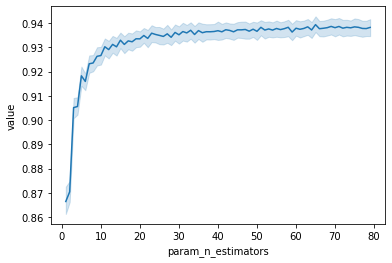

In [11]:
sns.lineplot(data = grid_acc,x='param_n_estimators',y='value')